In [228]:
#coding=utf-8
import PyKDL as kdl
import matplotlib.pyplot as plt
from urdf_parser_py.urdf import URDF
# from pykdl_utils.kdl_parser import kdl_tree_from_urdf_model
import numpy as np
from scipy.spatial.transform import Rotation as R
import copy

In [2]:
def get_urdf_parameter(joint_id,xml_obj):
    """ get inertial data. """
    # mass = xml_obj.getElementsByTagName("mass")[joint_id].getAttribute("value")
    rpy  = xml_obj.getElementsByTagName("joint")[joint_id].getElementsByTagName("origin")[0].getAttribute("rpy").split(" ")
    rpy  = tuple([float(i) for i in rpy])
    axis  = xml_obj.getElementsByTagName("joint")[joint_id].getElementsByTagName("axis")[0].getAttribute("xyz").split(" ")
    axis  = np.array(axis,dtype=np.float32)
    xyz  = xml_obj.getElementsByTagName("joint")[joint_id].getElementsByTagName("origin")[0].getAttribute("xyz").split(" ")
    xyz  = np.array(xyz,dtype=np.float32)
    data = [axis, rpy,xyz]
    return data

In [3]:
from urdf_parser_py.urdf import Robot

def euler_to_quat(r, p, y):
    sr, sp, sy = np.sin(r/2.0), np.sin(p/2.0), np.sin(y/2.0)
    cr, cp, cy = np.cos(r/2.0), np.cos(p/2.0), np.cos(y/2.0)
    return [sr*cp*cy - cr*sp*sy,
            cr*sp*cy + sr*cp*sy,
            cr*cp*sy - sr*sp*cy,
            cr*cp*cy + sr*sp*sy]

def urdf_pose_to_kdl_frame(pose):
    pos = [0., 0., 0.]
    rot = [0., 0., 0.]
    if pose is not None:
        if pose.position is not None:
            pos = pose.position
        if pose.rotation is not None:
            rot = pose.rotation
    return kdl.Frame(kdl.Rotation.Quaternion(*euler_to_quat(*rot)),
                     kdl.Vector(*pos))

def urdf_joint_to_kdl_joint(jnt):
    origin_frame = urdf_pose_to_kdl_frame(jnt.origin)
    if jnt.joint_type == 'fixed':
        return kdl.Joint(jnt.name, kdl.Joint.Fixed)
    axis = kdl.Vector(*jnt.axis)
    if jnt.joint_type == 'revolute':
        return kdl.Joint(jnt.name, origin_frame.p,
                         origin_frame.M * axis, kdl.Joint.RotAxis)
    if jnt.joint_type == 'continuous':
        return kdl.Joint(jnt.name, origin_frame.p,
                         origin_frame.M * axis, kdl.Joint.RotAxis)
    if jnt.joint_type == 'prismatic':
        return kdl.Joint(jnt.name, origin_frame.p,
                         origin_frame.M * axis, kdl.Joint.TransAxis)
    # prin "Unknown joint type: %s." % jnt.joint_type
    return kdl.Joint(jnt.name, kdl.Joint.Fixed)

def urdf_inertial_to_kdl_rbi(i):
    origin = urdf_pose_to_kdl_frame(i.origin)
    rbi = kdl.RigidBodyInertia(i.mass, origin.p,
                               kdl.RotationalInertia(i.inertia.ixx,
                                                     i.inertia.iyy,
                                                     i.inertia.izz,
                                                     i.inertia.ixy,
                                                     i.inertia.ixz,
                                                     i.inertia.iyz))
    return origin.M * rbi

##
# Returns a PyKDL.Tree generated from a urdf_parser_py.urdf.URDF object.
def kdl_tree_from_urdf_model(urdf):
    root = urdf.get_root()
    tree = kdl.Tree(root)
    def add_children_to_tree(parent):
        if parent in urdf.child_map:
            for joint, child_name in urdf.child_map[parent]:
                child = urdf.link_map[child_name]
                if child.inertial is not None:
                    kdl_inert = urdf_inertial_to_kdl_rbi(child.inertial)
                else:
                    kdl_inert = kdl.RigidBodyInertia()
                kdl_jnt = urdf_joint_to_kdl_joint(urdf.joint_map[joint])
                kdl_origin = urdf_pose_to_kdl_frame(urdf.joint_map[joint].origin)
                kdl_sgm = kdl.Segment(child_name, kdl_jnt,
                                      kdl_origin, kdl_inert)
                tree.addSegment(kdl_sgm, parent)
                add_children_to_tree(child_name)
    add_children_to_tree(root)
    return tree

In [4]:
robot = URDF.from_xml_file("dofbot.urdf")

In [5]:
xml_string = robot.to_xml_string()
# print(xml_string)
tree = kdl_tree_from_urdf_model(robot)

### Define necessary functions for IK test

In [6]:
def generate_random_pos(fk_solver):
    q = kdl.JntArray(5)
    q[0] = np.random.uniform(low=-np.pi, high=np.pi)
    q[1] = np.random.uniform(low=-np.pi, high=np.pi)
    q[2] = np.random.uniform(low=-np.pi, high=np.pi)
    q[3] = np.random.uniform(low=-np.pi, high=np.pi)
    q[4] = np.random.uniform(low=-np.pi, high=np.pi)
    end_effector_pose = kdl.Frame()
    
    fk_solver.JntToCart(q, end_effector_pose)
    R = np.random.uniform(low=-np.pi, high=np.pi)
    P = np.random.uniform(low=-np.pi, high=np.pi)
    Y = np.random.uniform(low=-np.pi, high=np.pi)
    random_points = end_effector_pose.p
    desired_pose = kdl.Frame(kdl.Rotation.RPY(R,P,Y), kdl.Vector(random_points[0],random_points[1],random_points[2]))
    # print(end_effector_pose.p)
    return desired_pose    
def kdl_to_np(M):
    if type(M) == kdl.Rotation:
        result = np.zeros([3,3])
        for i in range(3):
            for j in range(3):
                result[i,j] = M[i,j]
    else:
        result = []
        for v in M:
            result.append(v)
        result = np.array(result)
    return result

#### Test single pose 

In [7]:
chain = tree.getChain("base_link", "link5")
fk_solver = kdl.ChainFkSolverPos_recursive(chain)
number_of_joints = chain.getNrOfJoints()
q = kdl.JntArray(5)
q[1] = np.pi/3
q[2]  = np.pi/3
# Create a frame to hold the end effector pose result
end_effector_pose = kdl.Frame()

# Calculate forward kinematics
fk_solver.JntToCart(q, end_effector_pose)
# Create the inverse kinematics solver
ik_solver = kdl.ChainIkSolverPos_LMA(chain,eps=1e-4,maxiter=10000)

# Desired end-effector pose

desired_pose = kdl.Frame(kdl.Rotation.RPY(0, 0, 0), kdl.Vector(0.11, 0.02, 0.12))
# Solution joint positions will be stored here
solution = kdl.JntArray(number_of_joints)
q_int = kdl.JntArray(5)
q_int[0]  = -np.arctan2(desired_pose.p[0], desired_pose.p[1])
# Calculate inverse kinematics
status = ik_solver.CartToJnt(q_int, desired_pose, solution)

print(status)
if status >= 0:
    print("Solution found!") 
    # `solution` now contains the joint positions
else:
    print("No Solution")
    
print(solution)

0
Solution found!
[    -1.39094    -1.39003    -1.34957     2.73912     1.39094]


In [8]:
solutions = []
error_codes = []
pos_diffs = []
angle_diffs = []
desired_pose_list = []

In [9]:
for i in range(1000):
    desired_pose =  generate_random_pos(fk_solver)
    desired_pose_list.append(desired_pose)
    
for desired_pose in desired_pose_list:
    # Solution joint positions will be stored here
    solution = kdl.JntArray(number_of_joints)
    q_int = kdl.JntArray(5)
    q_int[0]  = -np.arctan2(desired_pose.p[0], desired_pose.p[1])
    # Calculate inverse kinematics
    status = ik_solver.CartToJnt(q_int, desired_pose, solution)
    end_effector_pose2 = kdl.Frame()
    fk_solver.JntToCart(solution, end_effector_pose2)
    
    pos_diff = end_effector_pose2.p - desired_pose.p
    pos_diff = np.array([pos_diff[0],pos_diff[1],pos_diff[2]])
    R0 = desired_pose.M 
    R1 = end_effector_pose2.M
    R0 = kdl_to_np(R0)
    R1 = kdl_to_np(R1)
    # Convert rotation matrices to axis-angle representation
    r0 = R.from_matrix(R0).as_rotvec()
    r1 = R.from_matrix(R1).as_rotvec()
            
    # Compute the angle between the two axes
    angle = np.arccos(np.dot(r0, r1) / (np.linalg.norm(r0) * np.linalg.norm(r1)))
    
    # Convert angle to degrees (if needed)
    angle_degrees = np.degrees(angle)
    
    # Convert angle to radians
    angle_radians = np.deg2rad(angle_degrees)
    
    # Convert angle to the range [-pi/2, pi/2]
    angle_mod = ((angle_radians + np.pi/2) % np.pi) - np.pi/2
    
    angle_diffs.append(abs(angle_mod))
    pos_diffs.append(np.linalg.norm(pos_diff))
    error_codes.append(status)
    solutions.append(solution)
    # pos_diff.append()
# print(error_code)
# print(solutions)
# print(pos_diffs)

In [10]:
R0

array([[ 0.88206613, -0.405237  , -0.24029631],
       [ 0.46413903,  0.83496786,  0.29564105],
       [ 0.08083501, -0.37230585,  0.92458318]])

In [11]:
angle_check = np.array(angle_diffs) > np.pi/4
pos_check = np.array(pos_diffs) > 0.005
combined_check = np.logical_or(angle_check, pos_check)
# Perform element-wise logical OR operation
acceptable_angle_rate = 1-np.count_nonzero(angle_check)/len(angle_diffs)
acceptable_pos_rate  = 1-np.count_nonzero(pos_check)/len(pos_diffs)
acceptable_rate  = 1-np.count_nonzero(combined_check)/len(pos_diffs)


In [12]:
print("acceptable angle rate: ", acceptable_angle_rate)
print("acceptable pos rate: ", acceptable_pos_rate)
print("acceptable rate: ", acceptable_rate)


acceptable angle rate:  0.891
acceptable pos rate:  0.97
acceptable rate:  0.864


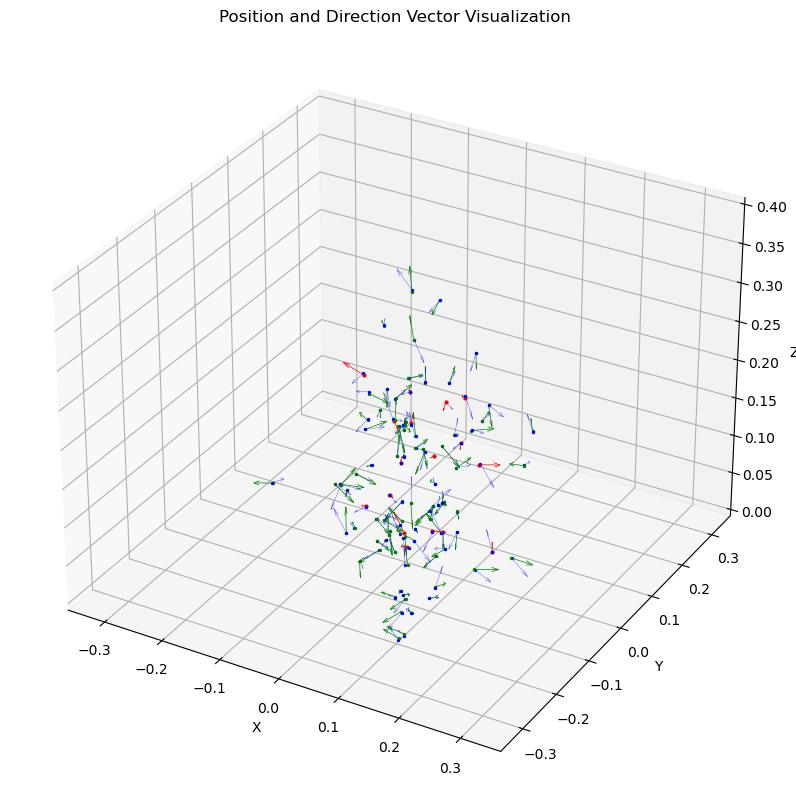

In [13]:
import numpy as np
import matplotlib.pyplot as plt
# Enable interactive plots
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

# Create a Matplotlib figure and 3D axis with adjusted size
fig = plt.figure(figsize=(10, 10),dpi=100)
ax = fig.add_subplot(111, projection='3d')

# Define the position and direction vectors
for desired_pose in desired_pose_list[:100]:
    pos = np.array([desired_pose.p[0], desired_pose.p[1], desired_pose.p[2]])  # Position vector
    rot = kdl_to_np(desired_pose.M)
    rotvec = R.from_matrix(rot).as_rotvec()
    direction = rotvec  # Direction vector
    # Plot the position vector as a point
    ax.scatter(pos[0], pos[1], pos[2], color='blue', s = 2,alpha=1)
    # Plot the direction vector as an arrow starting from the position
    ax.quiver(pos[0], pos[1], pos[2], direction[0], direction[1], direction[2], color='blue', length=0.012,linewidth=0.2)
for index, solution in enumerate(solutions[:100]):
    pose = kdl.Frame()
    fk_solver.JntToCart(solution, pose)
    pos = np.array([pose.p[0], pose.p[1], pose.p[2]])  # Position vector
    rot = kdl_to_np(pose.M)
    rotvec = R.from_matrix(rot).as_rotvec()
    direction = rotvec  # Direction vector
    # Plot the position vector as a point
    if pos_diffs[index]<0.005 and angle_diffs[index]<np.pi/4:
        ax.scatter(pos[0], pos[1], pos[2], color='green', s = 2,alpha=1)
        # Plot the direction vector as an arrow starting from the position
        ax.quiver(pos[0], pos[1], pos[2], direction[0], direction[1], direction[2], color='green', length=0.012,linewidth=0.5)
    else:
        ax.scatter(pos[0], pos[1], pos[2], color='red', s = 4,alpha=1)
        # Plot the direction vector as an arrow starting from the position
        ax.quiver(pos[0], pos[1], pos[2], direction[0], direction[1], direction[2], color='red', length=0.012,linewidth=0.5)
# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Position and Direction Vector Visualization')

# Set limits for better visualization (optional)
ax.set_xlim(-0.35, 0.35)
ax.set_ylim(-0.35, 0.35)
ax.set_zlim(0, 0.4)

# Show plot
plt.show()


### Interpolation algorithm

In [240]:
from scipy.special import comb

def bernstein_poly(i, n, t):
    """
     The Bernstein polynomial of n, i as a function of t
    """

    return comb(n, i) * ( t**(n-i) ) * (1 - t)**i


def bezier_curve(points, nTimes=1000):
    """
       Given a set of control points, return the
       bezier curve defined by the control points.

       points should be a list of lists, or list of tuples
       such as [ [1,1], 
                 [2,3], 
                 [4,5], ..[Xn, Yn] ]
        nTimes is the number of time steps, defaults to 1000

        See http://processingjs.nihongoresources.com/bezierinfo/
    """

    nPoints = len(points)
    xPoints = np.array([p[0] for p in points])
    yPoints = np.array([p[1] for p in points])

    t = np.linspace(0.0, 1.0, nTimes)

    polynomial_array = np.array([ bernstein_poly(i, nPoints-1, t) for i in range(0, nPoints)   ])

    xvals = np.dot(xPoints, polynomial_array)
    yvals = np.dot(yPoints, polynomial_array)

    return xvals, yvals



In [241]:
start_pose = desired_pose_list[np.random.randint(100)]
end_pose = desired_pose_list[np.random.randint(100)]
end_pose.M = start_pose.M

[[   -0.445915,   -0.348076,   -0.824623;
     0.297048,   -0.926624,    0.230501;
    -0.844347,   -0.142169,    0.516591]
[     0.11295,   0.0658264,    0.004628]]

In [243]:
q_start =  kdl.JntArray(5)
q_end = kdl.JntArray(5)
q_int = kdl.JntArray(5)
ik_solver.CartToJnt(q_int, start_pose, q_start)
ik_solver.CartToJnt(q_int, end_pose, q_end)

-101

In [244]:
from scipy.spatial.transform import Rotation
from scipy.spatial.transform import Slerp

def interpolate_orientation(start_orientation, end_orientation, num_points):
    start_rot = Rotation.from_matrix(start_orientation).as_euler('xyz')
    end_rot = Rotation.from_matrix(end_orientation).as_euler('xyz')
    print(start_rot)
    key_rots = Rotation.from_euler('xyz', np.stack((start_rot, end_rot)))
    
    slerp = Slerp([0, 1], key_rots)
    interpolated_rotations = slerp(np.linspace(0, 1, num_points))
    orientations = interpolated_rotations.as_euler('xyz')

    return orientations

# Assuming start_pose.M and end_pose.M are rotation matrices
start_rot = kdl_to_np(start_pose.M)
end_rot = kdl_to_np(end_pose.M)
num_points = 10  # Example number of intermediate orientations

ori_intermediate = interpolate_orientation(start_rot, end_rot, num_points)


[-0.2685578   1.00534531  2.55394453]


In [245]:
start_position = start_pose.p
end_position = end_pose.p
x0,y0,z0 = start_position
x1,y1,z1 = end_position

# Number of intermediate points (including the endpoints)
num_points = 10

# Generate intermediate x, y, z values using linear interpolation
x_intermediate = np.linspace(x0, x1, num_points)
y_intermediate = np.linspace(y0, y1, num_points)
z_intermediate = np.linspace(z0, z1, num_points)

line_intermediate = np.column_stack((x_intermediate,y_intermediate,z_intermediate))
q_int = kdl.JntArray(5)
q_prev = q_int
q_current = kdl.JntArray(5)
q_intermediate = np.zeros((num_points, 5))


In [246]:
pose_intermediate = []
q_intermediate = []
for i in range(num_points):
    R,P,Y = ori_intermediate[i]
    x,y,z = line_intermediate[i]
    desired_pose = kdl.Frame(kdl.Rotation.RPY(R,P,Y), kdl.Vector(x,y,z))
    rot = kdl_to_np(desired_pose.M)
    pos = kdl_to_np(desired_pose.p)
    pose = np.append(rot,pos).reshape(4,3)
    pose_intermediate.append(desired_pose)
    
    
for i, pos in enumerate(pose_intermediate):
    
    q_int = q_prev
    ik_solver.CartToJnt(q_int, pos, q_current)
    q_intermediate.append(kdl_to_np(q_current))
    q_prev = q_current
q_intermediate = np.asarray(q_intermediate)    

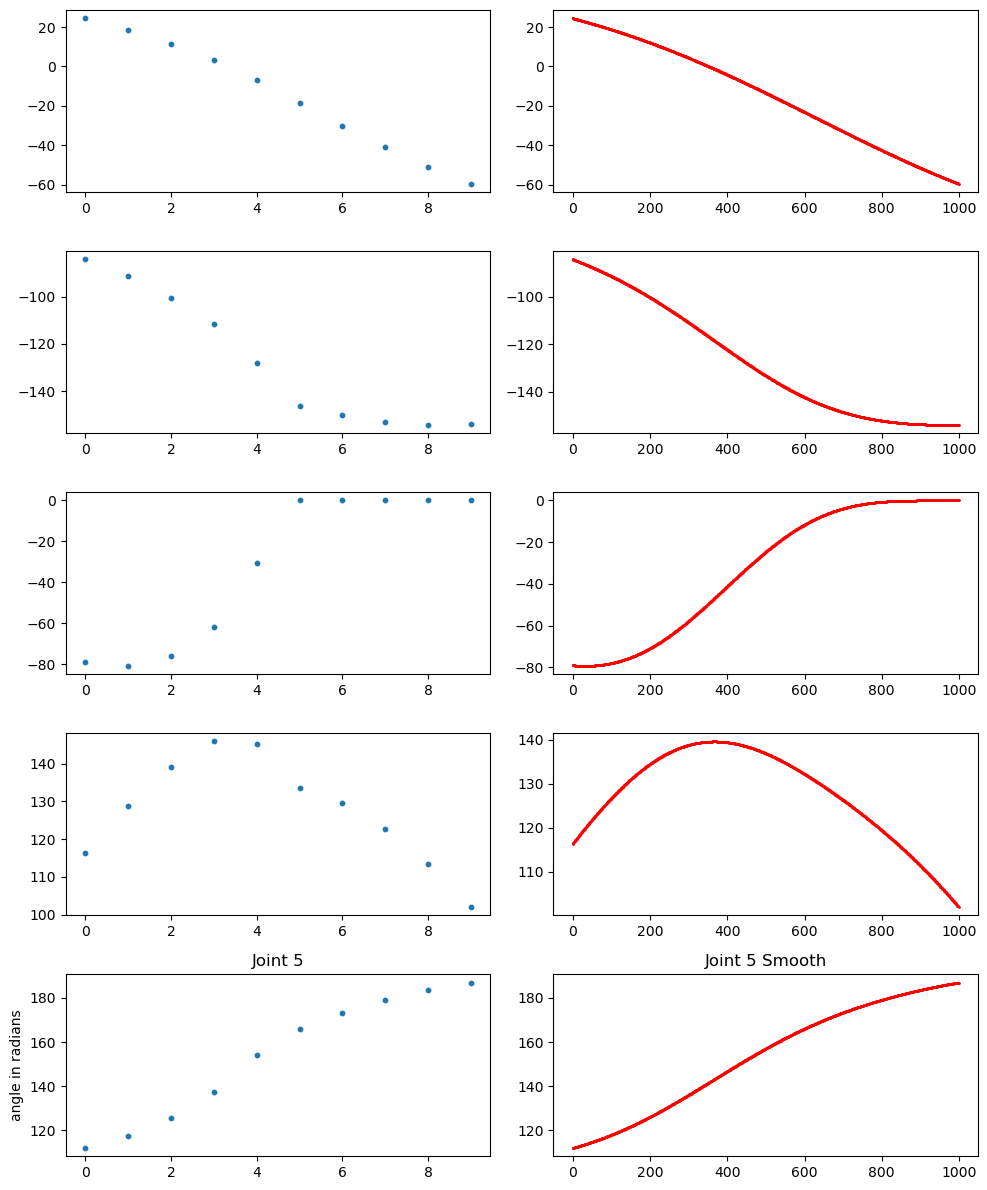

In [253]:
import numpy as np
import matplotlib.pyplot as plt
q_smooth_list = []
# Assuming q_intermediate contains the joint positions of the 5 joints
# Each row represents the joint positions at a specific time step
# Each column represents the position of a joint in 3D space (x, y, z)
# Shape of q_intermediate should be (num_points, num_joints, 3)
num_points, num_joints = q_intermediate.shape

# Create a figure with 5 subplots arranged horizontally
fig, axs = plt.subplots(num_joints,2, figsize=(10, 12))  # Adjust figsize as needed
# Plot the positions of the joints in each subplot

for i, ax in enumerate(axs):
    ax[0].scatter(range(num_points), q_intermediate[:, i]*180/np.pi,label='joint'+str(j),s=10)
    q_smooth = np.flip(bezier_curve(np.column_stack((np.arange(10),q_intermediate[:,i])),nTimes=1000)[1])    
    ax[1].scatter(range(1000), q_smooth*180/np.pi,label='joint'+str(i),s=1,color='r')
    q_smooth_list.append(q_smooth)     
ax[0].set_title(f'Joint {i+1}')
ax[1].set_title(f'Joint {i+1} Smooth')

#     ax.set_xlabel('Time Step')
ax[0].set_ylabel('angle in radians')
    

# Adjust layout and show plot
plt.tight_layout()
plt.show()

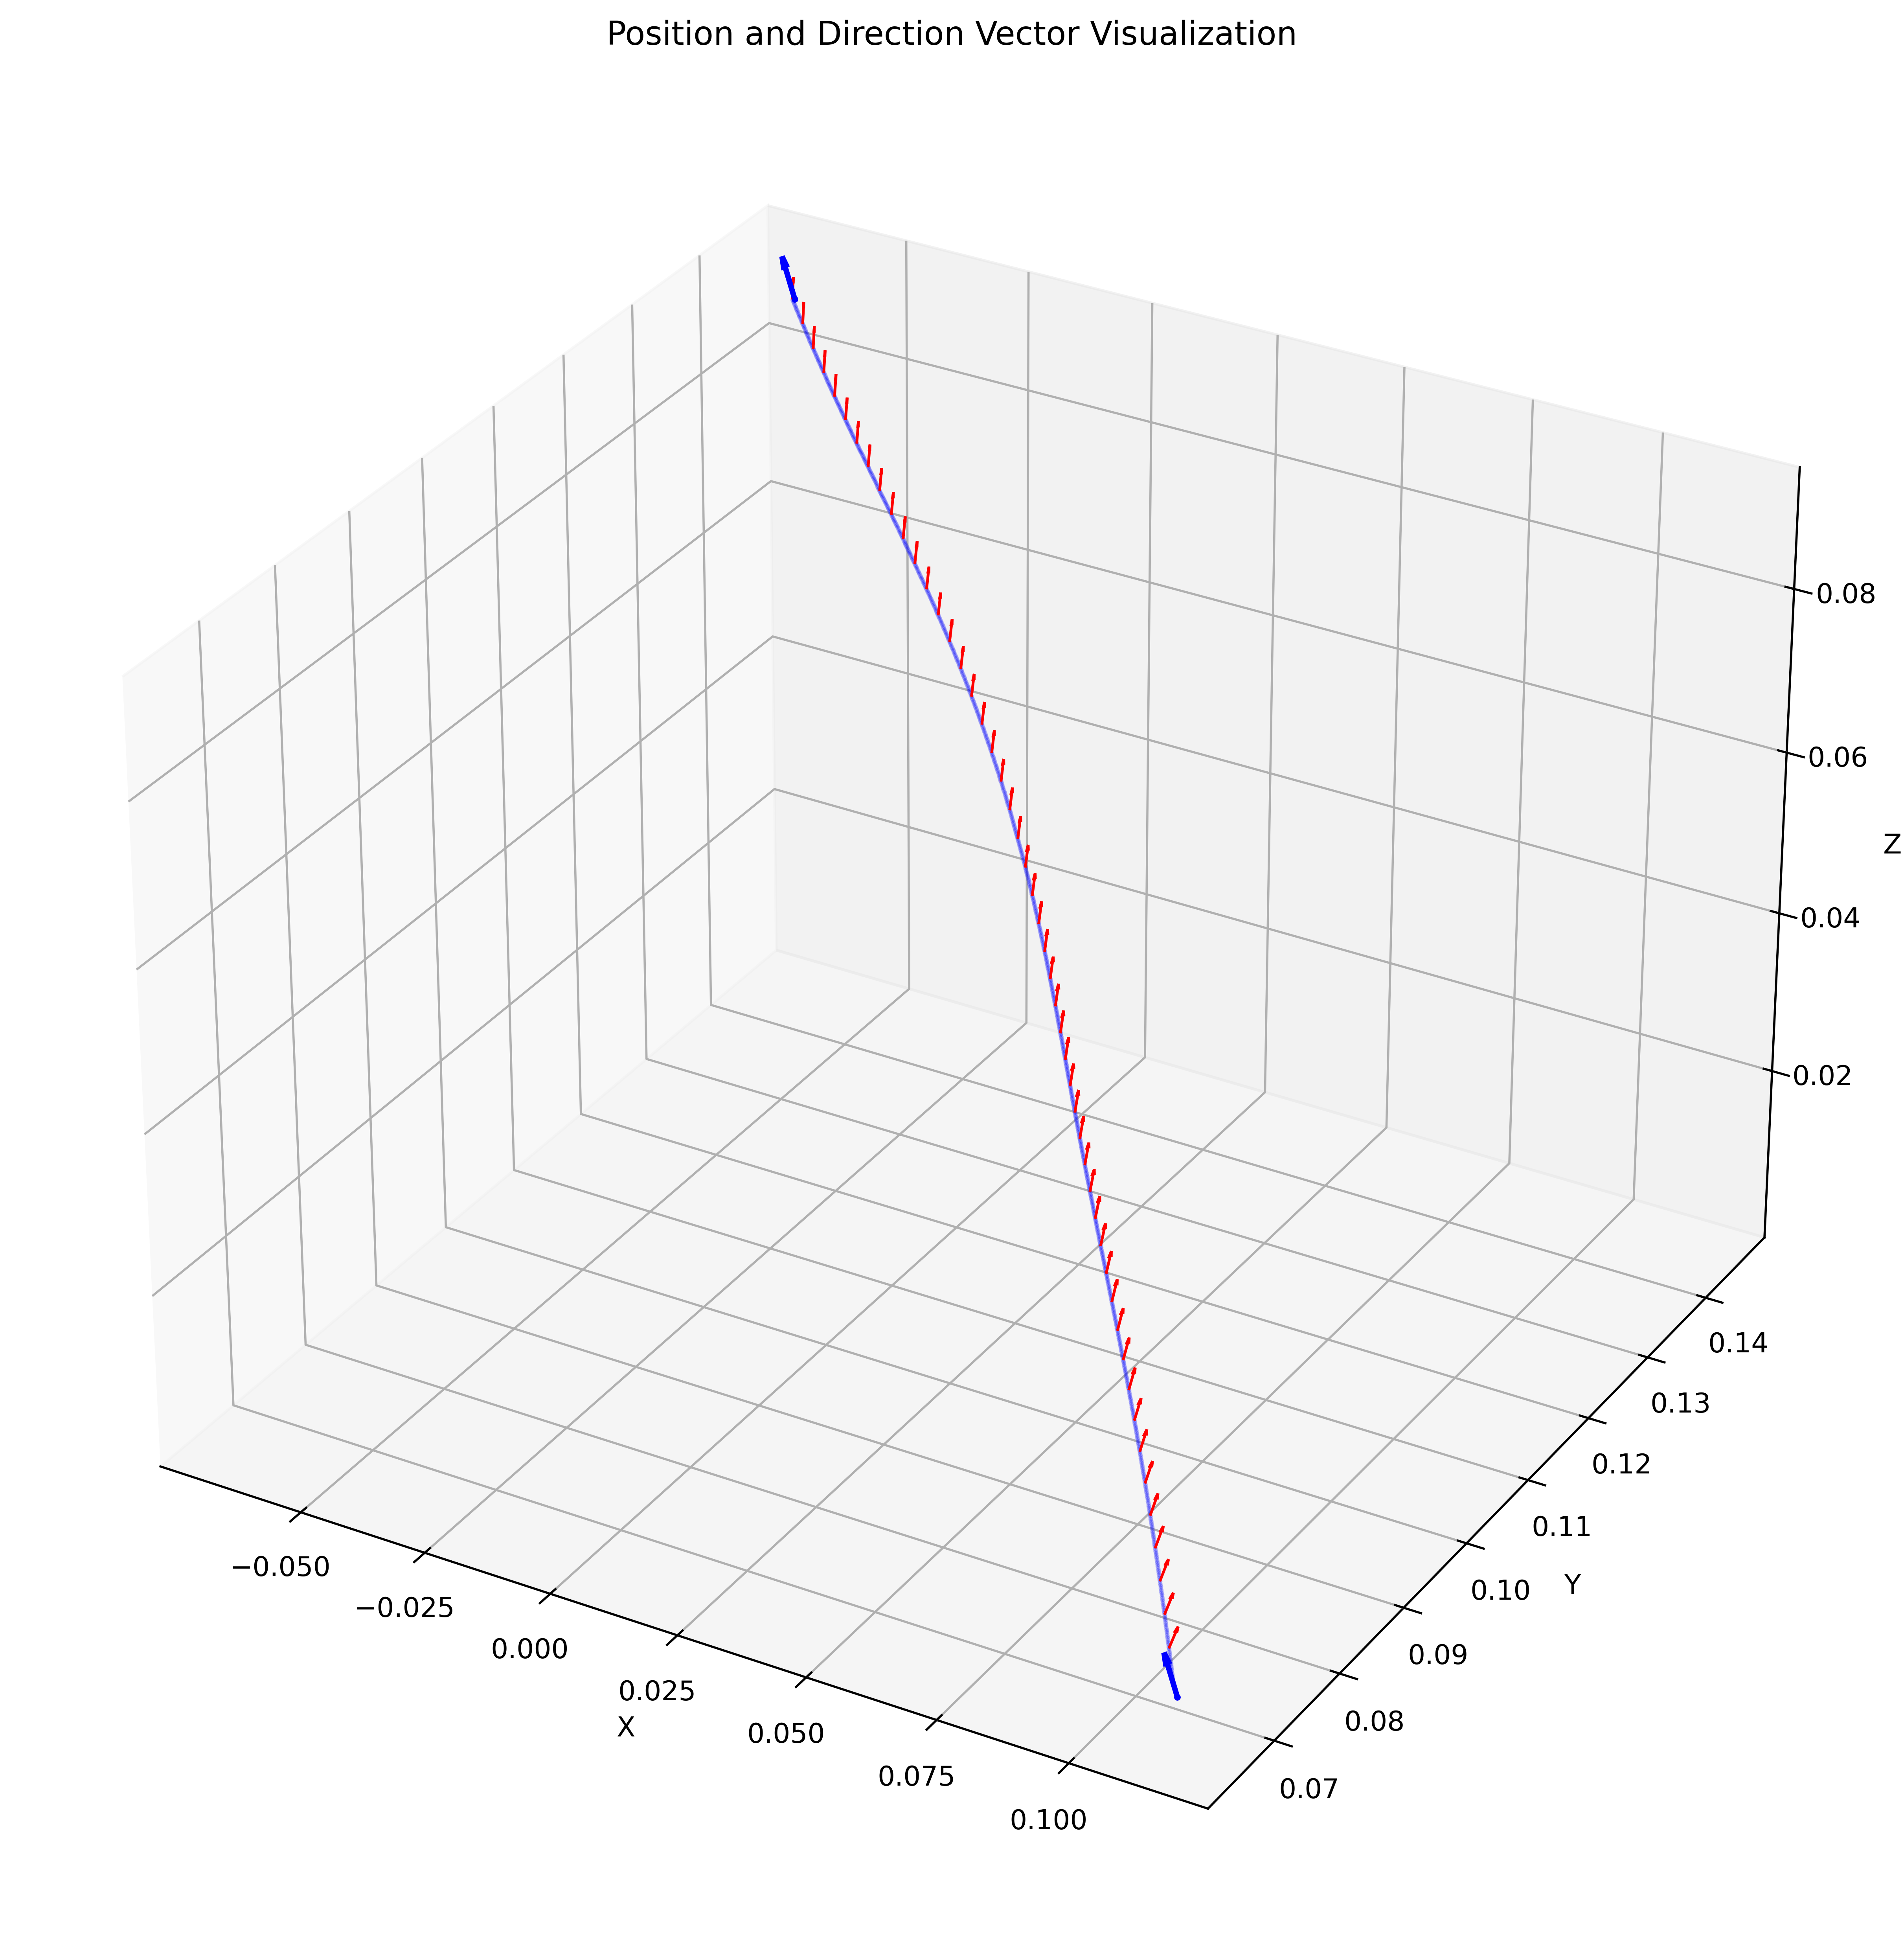

In [256]:
fig = plt.figure(figsize=(10, 10), dpi=500)
ax = fig.add_subplot(111, projection='3d')

# Define the position and direction vectors for start and end poses
pose = [start_pose, end_pose]
for p in pose:
    pos = kdl_to_np(p.p)
    rot = kdl_to_np(p.M)
    rotvec = Rotation.from_matrix(rot).as_rotvec()
    direction = rotvec  # Direction vector
    
    # Plot the position vector as a point
    ax.scatter(pos[0], pos[1], pos[2], color='blue', s=2, alpha=1)
    
    # Plot the direction vector as an arrow starting from the position
    ax.quiver(pos[0], pos[1], pos[2], direction[0], direction[1], direction[2], color='blue', length=0.002, linewidth=2)

# Plot intermediate poses
for i in range(1000):
    solution = kdl.JntArray(5)
    solution[0] = np.array(q_smooth_list).T[i][0]
    solution[1] = np.array(q_smooth_list).T[i][1]
    solution[2] = np.array(q_smooth_list).T[i][2]
    solution[3] = np.array(q_smooth_list).T[i][3]
    solution[4] = np.array(q_smooth_list).T[i][4]
    
    end_effector_pose = kdl.Frame()
    fk_solver.JntToCart(solution, end_effector_pose)
    
    pos = kdl_to_np(end_effector_pose.p)
    rot = kdl_to_np(end_effector_pose.M)
    rotvec = Rotation.from_matrix(rot).as_rotvec()
    direction = (rotvec)  # Direction vector
    # Plot the position vector as a point
    ax.scatter(pos[0], pos[1], pos[2], color='blue', s=0.5, alpha=0.2)
    if i%20 == 0:
        
        
        # Plot the direction vector as an arrow starting from the position
        ax.quiver(pos[0], pos[1], pos[2], (direction[0]), (direction[1]), (direction[2]), color='r', length=0.001, linewidth=1)

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Position and Direction Vector Visualization')

# # Set limits for better visualization (optional)
# ax.set_xlim(-0.35, 0.35)
# ax.set_ylim(-0.35, 0.35)
# ax.set_zlim(0, 0.4)
plt.tight_layout()
# Show plot
plt.show()


In [249]:
start_pose.p

[  -0.0653748,    0.144583,   0.0885296]